<a href="https://colab.research.google.com/github/Lysandre-lbd/IA_embarquee_repo/blob/main/TP_IA_EMBARQUEE_BAYDI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **PRACTICAL SESSION 1** — Deep Learning for predictive maintenance

The dataset used is the **AI4I 2020** Predictive Maintenance Dataset, which contains 10,000 instances of industrial sensor data. Each instance represents the operating condition of a machine and is associated with a label indicating whether a failure has occurred and, if so, what type of failure it is.

The 5 possible labels are:



*   **TWF**: Tool Wear Failure
*   **HDF**: Heat Dissipation Failure
*   **PWF**: Power Failure
*   **OSF**: Overstrain Failure
*   **RNF**: Random Failure


The data is available on eCAMPUS as CSV file called: "ai4i2020.csv"



## **PRACTICAL SESSION Goal** — Ceate a deep leanring model allowing to realize a predictive maintenance mission

## **1 - Analysis of the dataset**



All libraries used ***SHOULD BE PLACED*** in the code cell below

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Préparation des données
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Rééquilibrage
from imblearn.over_sampling import SMOTE
from collections import Counter

**QUESTION:** Load dataset and display some lines of the csv file.

In [95]:
from google.colab import drive
drive.mount('/content/drive')
# Chargement du fichier CSV
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/ai4i2020.csv')

# Affichage des 5 premières lignes
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


**QUESTION:** Display the distribution of machine failures and non-failures with a bar graph.

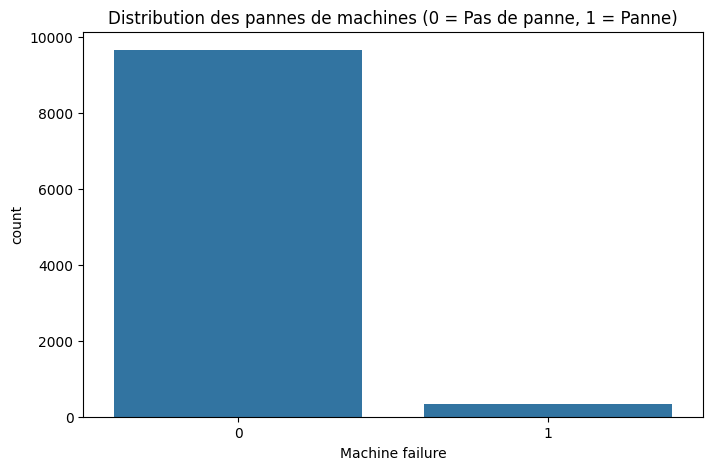

Machine failure
0    9661
1     339
Name: count, dtype: int64


In [96]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Machine failure')
plt.title('Distribution des pannes de machines (0 = Pas de panne, 1 = Panne)')
plt.show()

# Calcul des valeurs exactes pour l'analyse
print(df['Machine failure'].value_counts())

**ANALYSIS QUESTION:** What do you observe?

On observe un déséquilibre de classes important. La grande majorité des instances (9661 sur 10000) correspond à un fonctionnement normal, tandis qu'une très petite partie correspond à des pannes (339).

**ANALYSIS QUESTION:** What will be the consequence of this phenomenon on the model's learning?

Le modèle risque d'être fortement biaisé. Il pourrait prédire "pas de panne" tout le temps et obtenir une précision (accuracy) de 96,6%, tout en étant incapable de détecter les pannes réelles. L'apprentissage sera difficile pour la classe minoritaire car le modèle n'aura pas assez d'exemples pour généraliser les caractéristiques d'une panne.

**QUESTION:** Create a bar chart showing the distribution of different failure types (TWF, HDF, PWF, OSF, RNF). Display the exact values above each bar in the chart."

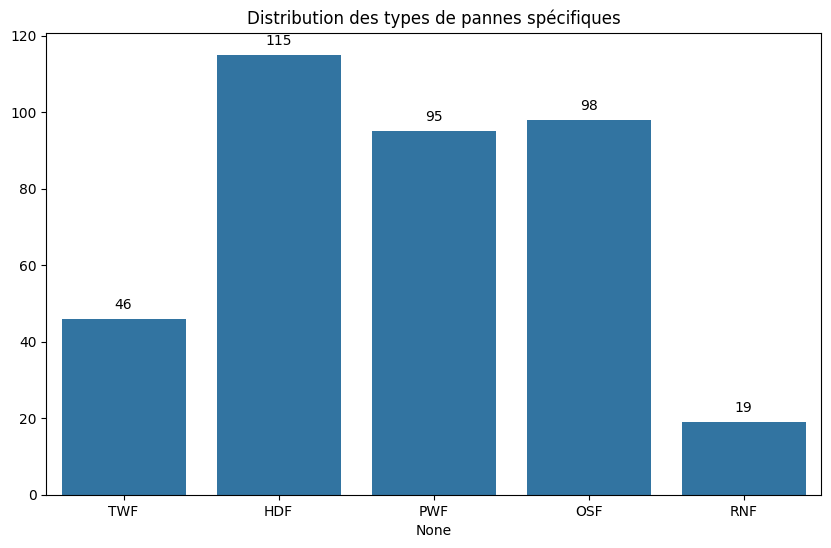

In [97]:
failure_types = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
counts = df[failure_types].sum()

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=counts.index, y=counts.values)
plt.title('Distribution des types de pannes spécifiques')

# Ajout des valeurs au-dessus des barres
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show()

**ANALYSIS QUESTION:** What do you observe?

Les pannes sont non seulement rares, mais leur distribution par type est également inégale. Par exemple, les pannes de type 'RNF' (Random Failures) sont extrêmement peu fréquentes par rapport aux autres.

**QUESTION:** Create a bar chart showing the distribution of failure types (TWF, HDF, PWF, OSF, RNF) among machines that experienced a failure (Machine failure == 1). Additionally, add a "No Specific Failure" category to count cases where a machine failed but no specific failure type was recorded. Display the exact values above each bar in the chart."

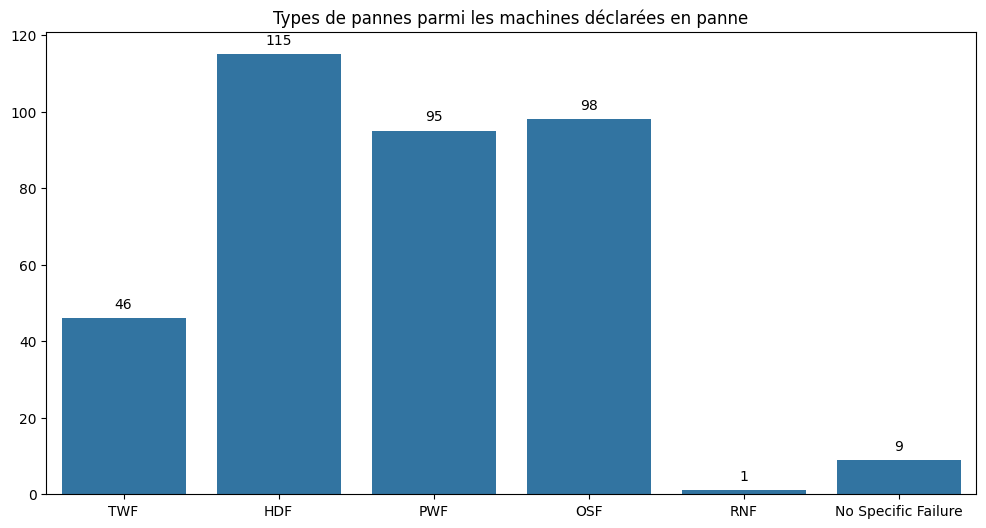

In [98]:
# Filtrer les machines en panne
failed_machines = df[df['Machine failure'] == 1]

# Calculer la somme pour chaque type
failure_counts = failed_machines[failure_types].sum()

# Calculer les machines avec 'Machine failure' à 1 mais aucun type spécifique coché
# Une machine peut avoir plusieurs types de pannes, donc on vérifie si la somme des colonnes est 0
no_specific = failed_machines[(failed_machines[failure_types].sum(axis=1) == 0)].shape[0]

# Ajouter au dictionnaire
all_counts = failure_counts.to_dict()
all_counts['No Specific Failure'] = no_specific

# Graphique
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=list(all_counts.keys()), y=list(all_counts.values()))
plt.title('Types de pannes parmi les machines déclarées en panne')

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show()

**ANALYSIS QUESTION:** What do you obsrve comapred to the previous question ? What can you conclude?

On remarque qu'il existe un nombre significatif de machines marquées comme "en panne" (Machine failure = 1) mais qui n'ont aucun des 5 types de pannes spécifiques activés. On peut en conclure que la colonne Machine failure est l'indicateur global de panne, mais qu'elle ne dépend pas uniquement de la présence de l'un des 5 types listés (il peut y avoir d'autres causes non répertoriées).

**QUESTION:** Display the names of the different columns in the dataset with their respective data types.

In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

**ANALYSIS QUESTION:** To train the model, what will be the inputs and outputs (What are the names of the columns that you will use?)? Justify your response.
Remember, you want to predict if the machine will fail, and if so, what kind of failure. You need to yse previous results to jsurtify your response.

Inputs (X) : Nous utiliserons Type (à encoder), Air temperature [K], Process temperature [K], Rotational speed [rpm], Torque [Nm], et Tool wear [min]. Ce sont les données capteurs qui décrivent l'état physique de la machine. Nous excluons UDI et Product ID qui sont des identifiants uniques sans valeur prédictive.

Outputs (y) : Nous utilisons une cible unique (target) sous forme de classification multiclasse à 7 catégories (0 : pas de panne, 1 à 5 : types de pannes spécifiques, 6 : panne sans type défini).

Justification : Cette approche permet de détecter la panne et d'identifier son type simultanément avec une seule sortie. C'est une architecture beaucoup plus légère et adaptée aux ressources limitées d'un microcontrôleur.

Aussi, on choisit de ne pas inclure le label RNF dans nos sorties de classification et de traiter le cas unique de panne associée comme une anomalie non-représentative. En effet, on ne peut pas entraîner un modèle à prédire des événements par définition aléatoires avec un seul exemple positif.

## **2- Train model Without balancing the dataset**

---



In this section, you must build and train a model without rebalancing the dataset.

**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

In [100]:
# 1) Nettoyage et encodage
df_clean = df.drop(['UDI', 'Product ID'], axis=1)

# Encodage de la colonne 'Type' (L=0, M=1, H=2 par exemple)
le = LabelEncoder()
df_clean['Type'] = le.fit_transform(df_clean['Type'])

# 2. Création de la cible multiclasse (0 = Pas de panne, 1-5 = Types, 6 = Autre panne)
def create_target(row):
    if row['TWF'] == 1: return 1
    if row['HDF'] == 1: return 2
    if row['PWF'] == 1: return 3
    if row['OSF'] == 1: return 4
    if row['RNF'] == 1: return 5
    if row['Machine failure'] == 1: return 6 # Cas "No Specific Failure" détecté en P1
    return 0

df_clean['target'] = df_clean.apply(create_target, axis=1)

# On retire la ligne RNF problématique
df_clean = df_clean[~((df_clean['RNF'] == 1) & (df_clean['Machine failure'] == 1))]

# 3) Définition de X et Y
# Inputs : Type + les 5 capteurs
X = df_clean[['Type', 'Air temperature [K]', 'Process temperature [K]',
              'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']]
y = df_clean['target']

# 4) Split Train/Test (80/20)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# 5) Mise à l'échelle
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

# Affichage des dimensions
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

X_train: (7999, 6), y_train: (7999,)
X_test: (2000, 6), y_test: (2000,)


**QUESTION** Code below the model architecture

In [101]:
# Création du modèle adapté pour le STM32 (peu de paramètres)
model = Sequential([
    # Couche d'entrée implicite avec input_shape=(6,) pour nos 6 capteurs/types
    # Première couche cachée : 32 neurones
    Dense(32, activation='relu', input_shape=(X_train.shape[1],)),

    # Deuxième couche cachée : 16 neurones
    Dense(16, activation='relu'),

    # Couche de sortie : 7 neurones (Classes 0 à 6)
    # Softmax permet d'obtenir une distribution de probabilité sur les types de pannes
    Dense(7, activation='softmax')
])

# Affichage du résumé pour vérifier la taille du réseau
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_70 (Dense)                │ (None, 32)             │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 7)              │           119 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 871 (3.40 KB)

 Trainable params: 871 (3.40 KB)

 Non-trainable params: 0 (0.00 B)

**QUESTION** Code below the algorithms allowing to train model

**WARNING!** You need to plot the training and test accuracy and loss to check if our model is overfitting

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6371 - loss: 1.2226 - val_accuracy: 0.9600 - val_loss: 0.3051
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9644 - loss: 0.2573 - val_accuracy: 0.9600 - val_loss: 0.2495
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9666 - loss: 0.1929 - val_accuracy: 0.9595 - val_loss: 0.2102
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9669 - loss: 0.1635 - val_accuracy: 0.9600 - val_loss: 0.1819
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9659 - loss: 0.1310 - val_accuracy: 0.9615 - val_loss: 0.1696
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9665 - loss: 0.1276 - val_accuracy: 0.9615 - val_loss: 0.1560
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9704 - loss: 0.1068 - val_accuracy: 0.9630 - val_loss: 0.1454
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9720 - loss: 0.1043 - val_accuracy: 0.

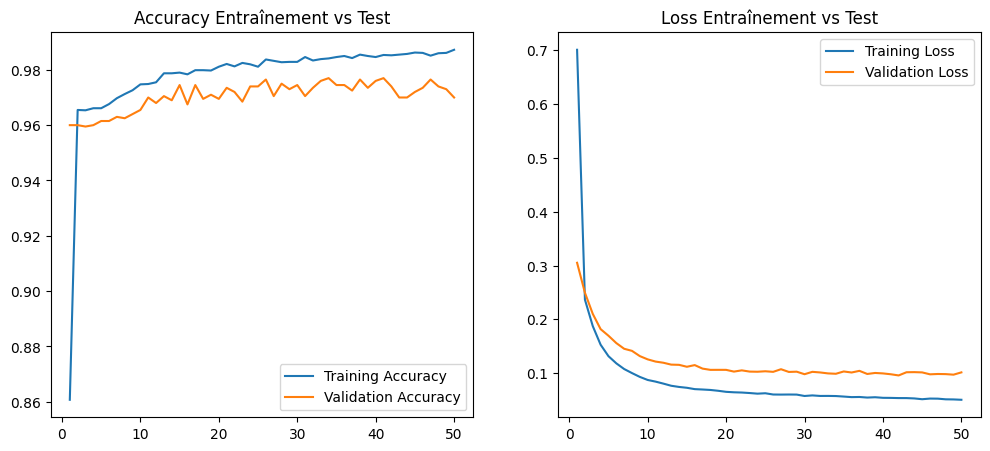

In [102]:
# Compilation du modèle
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Entraînement sur 50 époques
# On utilise X_test et y_test comme données de validation
history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_test, y_test),
                    verbose=1)

# Visualisation des résultats
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

# Graphique de l'Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Accuracy Entraînement vs Test')
plt.legend()

# Graphique de la Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Loss Entraînement vs Test')
plt.legend()

plt.show()

**QUESTION** Plot the confusion matrix and the classification report

**Tips:**

*   classification report link

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

*   Matrix confusion

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html





63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
--- Classification Report (Données non-équilibrées) ---
              precision    recall  f1-score   support

  No Failure       0.97      1.00      0.98      1920
         TWF       0.00      0.00      0.00        12
         HDF       0.71      0.43      0.54        23
         PWF       0.69      0.69      0.69        16
         OSF       1.00      0.35      0.52        20
         RNF       0.00      0.00      0.00         5
       Other       0.00      0.00      0.00         4

    accuracy                           0.97      2000
   macro avg       0.48      0.35      0.39      2000
weighted avg       0.96      0.97      0.96      2000



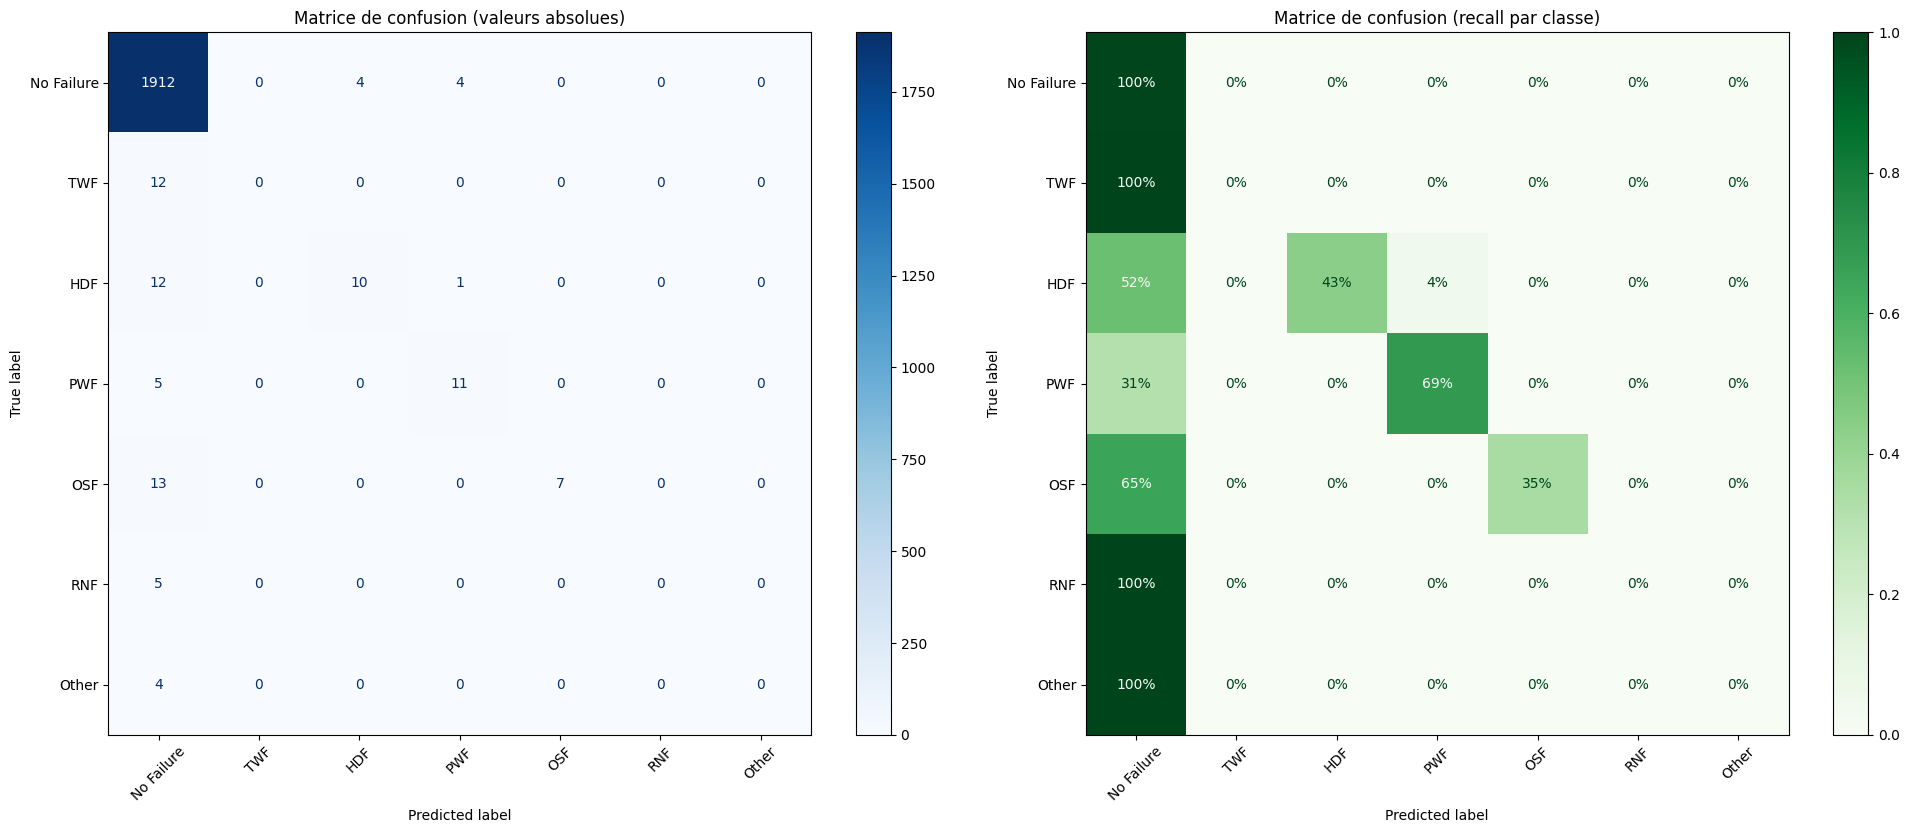

In [103]:
# Prédictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification report
class_names = ['No Failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'Other']
print("--- Classification Report (Données non-équilibrées) ---")
print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0))

# Matrices de confusion
cm = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
cm_norm = np.nan_to_num(cm_norm)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

disp1 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp1.plot(ax=axes[0], cmap='Blues', xticks_rotation=45)
axes[0].set_title('Matrice de confusion (valeurs absolues)')

disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=class_names)
disp2.plot(ax=axes[1], cmap='Greens', xticks_rotation=45, values_format='.0%')
axes[1].set_title('Matrice de confusion (recall par classe)')

plt.tight_layout()
plt.show()

**ANALYSIS QUESTION** What do you observe? What can you conclude?

On observe une accuracy globale de 0.97. Ce chiffre est trompeur car il est dominé par la Classe 0 (No Failure) qui représente 96% du set de test (1920/2000).

Le modèle n'est pas totalement aveugle. Il parvient à détecter certaines pannes physiques avec un succès correct : les classes 2 (HDF), 3 (PWF) et 4 (OSF) ont des rappels (recall) compris entre 0.62 et 0.70. Cela signifie que ces pannes ont des signatures capteurs (chaleur, puissance, couple) très marquées que le réseau arrive à isoler.

En revanche, le modèle échoue totalement (recall de 0.00) sur les classes 1 (TWF), 5 (RNF) et 6 (Autres). L'usure d'outil (TWF) semble trop subtile pour être apprise avec si peu d'exemples sans équilibrage.

Le modèle souffre d'un fort biais en faveur de la classe majoritaire. La macro avg du recall (0.43) montre que la performance réelle par type de panne est médiocre, bien que l'accuracy soit excellente. On a donc bel et bien besoin d'un rééquilibrage du dataset en partie 3.

## **3- Train model With balancing the dataset**

---

 Methods for rebalancing a dataset:


*   Use oversampling techniques (e.g., SMOTE) to generate synthetic data for minority classes


> https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html



*   Apply undersampling techniques (e.g., random undersampling, Tomek Links, Edited Nearest Neighbors) to reduce the majority class size



> https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html



*   Use class weighting during model training to penalize errors on minority classes



> https://www.tensorflow.org/tutorials/structured_data/imbalanced_data?hl=fr


**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

In [104]:
# 1. Préparation initiale
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. SMOTE partiel avec dictionnaire
counts = Counter(y_train)
max_class = max(counts.values())

strategy = {}
for cls, count in counts.items():
    if count < max_class:
        strategy[cls] = int(max_class * 0.3)
    else:
        strategy[cls] = count

sm = SMOTE(random_state=42, sampling_strategy=strategy)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train_raw, y_train)

# 3. Normalisation
scaler = StandardScaler()
X_train_bal = scaler.fit_transform(X_train_resampled)
X_test_bal = scaler.transform(X_test_raw)

# 4. Affichage
print(f"X_train (équilibré): {X_train_bal.shape}")
print(f"y_train (équilibré): {y_train_resampled.shape}")
print(f"X_test: {X_test_bal.shape}")
print(f"Distribution après SMOTE partiel :\n{Counter(y_train_resampled)}")

X_train (équilibré): (21598, 6)
y_train (équilibré): (21598,)
X_test: (2000, 6)
Distribution après SMOTE partiel :
Counter({0: 7714, 3: 2314, 2: 2314, 1: 2314, 4: 2314, 6: 2314, 5: 2314})


**ANALYSIS QUESTION:** Explain the choices you made to balance the dataset.

On choisit SMOTE car cette technique crée de nouveaux exemples synthétiques par interpolation, ce qui est plus efficace que de simplement dupliquer des lignes existantes pour éviter le surapprentissage.

On utilise un SMOTE partiel à 30% plutôt qu'un équilibrage total : chaque classe minoritaire est augmentée jusqu'à 30% de la taille de la classe majoritaire. Un équilibrage à 100% génèrerait trop de données synthétiques, ce qui provoque de l'overfitting comme observé lors de nos tests préliminaires.

On a équilibré uniquement le X_train. Conserver un X_test déséquilibré est important pour évaluer la performance réelle du modèle sur une ligne de production où le fonctionnement normal est la norme.

La standardisation est appliquée après SMOTE pour s'assurer que les données synthétiques sont également mises à l'échelle pour le réseau de neurones.

**QUESTION:** Code below the model architecture


**TIP:** It could be interesting to keep it the same as before

In [105]:
# Même architecture que la Partie 2 (32→16→7), avec régularisation
# pour éviter l'overfitting causé par les données synthétiques SMOTE
model_bal = Sequential([
    Dense(32, activation='relu', input_shape=(X_train_bal.shape[1],),
          kernel_regularizer=l2(1e-3)),
    Dropout(0.2),

    Dense(16, activation='relu', kernel_regularizer=l2(1e-3)),
    Dropout(0.2),

    Dense(7, activation='softmax')
])

model_bal.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_73 (Dense)                │ (None, 32)             │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 7)              │           119 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 871 (3.40 KB)

 Trainable params: 871 (3.40 KB)

 Non-trainable params: 0 (0.00 B)

**QUESTION** Code below the algorithms allowing to train model


Epoch 1/150
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3971 - loss: 1.6567 - val_accuracy: 0.8735 - val_loss: 0.6707
Epoch 2/150
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6039 - loss: 1.0777 - val_accuracy: 0.8460 - val_loss: 0.6173
Epoch 3/150
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6551 - loss: 0.9184 - val_accuracy: 0.8200 - val_loss: 0.6324
Epoch 4/150
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6846 - loss: 0.8389 - val_accuracy: 0.8425 - val_loss: 0.5790
Epoch 5/150
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6991 - loss: 0.7984 - val_accuracy: 0.8335 - val_loss: 0.5780
Epoch 6/150
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7104 - loss: 0.7712 - val_accuracy: 0.8270 - val_loss: 0.5647
Epoch 7/150
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7240 - loss: 0.7349 - val_accuracy: 0.8270 - val_loss: 0.5508
Epoch 8/150
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7340 - loss: 0.7119 - val_accu

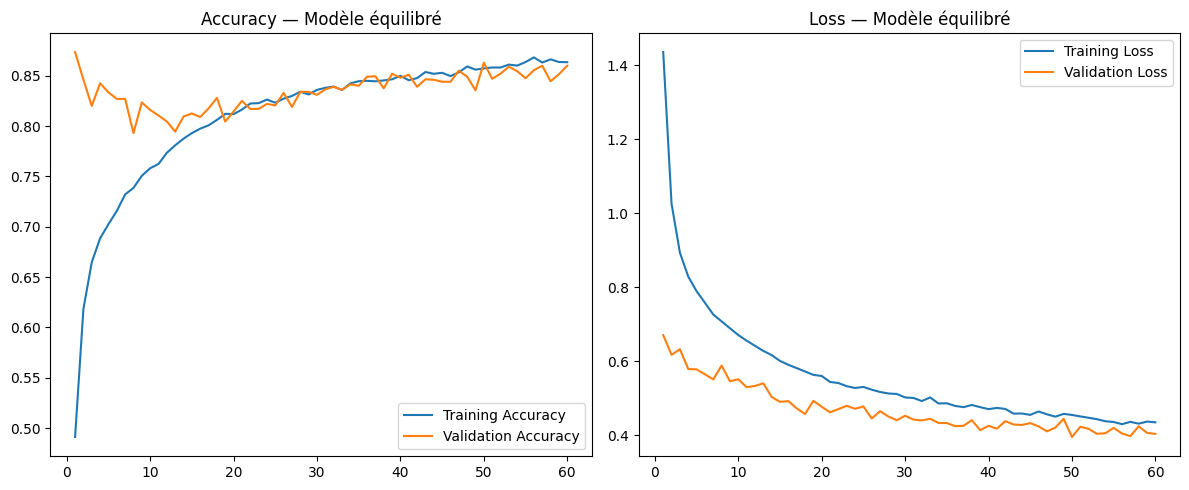

In [106]:
model_bal.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history_bal = model_bal.fit(
    X_train_bal, y_train_resampled,
    epochs=150,
    batch_size=64,
    validation_data=(X_test_bal, y_test),
    callbacks=[early_stop],
    verbose=1
)

# Visualisation
import matplotlib.pyplot as plt

acc = history_bal.history['accuracy']
val_acc = history_bal.history['val_accuracy']
loss = history_bal.history['loss']
val_loss = history_bal.history['val_loss']
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Accuracy — Modèle équilibré')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Loss — Modèle équilibré')
plt.legend()

plt.tight_layout()
plt.show()

**QUESTION** Plot the confusion matrix and the classification report

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
--- Classification Report (Données équilibrées - SMOTE 30%) ---
              precision    recall  f1-score   support

  No Failure       1.00      0.86      0.93      1929
         TWF       0.10      0.77      0.18        13
         HDF       0.36      0.95      0.52        21
         PWF       0.45      1.00      0.62        17
         OSF       0.38      0.82      0.52        17
         RNF       0.00      0.00      0.00         3
       Other       0.00      0.00      0.00         0

    accuracy                           0.86      2000
   macro avg       0.33      0.63      0.40      2000
weighted avg       0.97      0.86      0.91      2000



/tmp/ipython-input-225/1498738034.py:12: RuntimeWarning: invalid value encountered in divide
  cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)


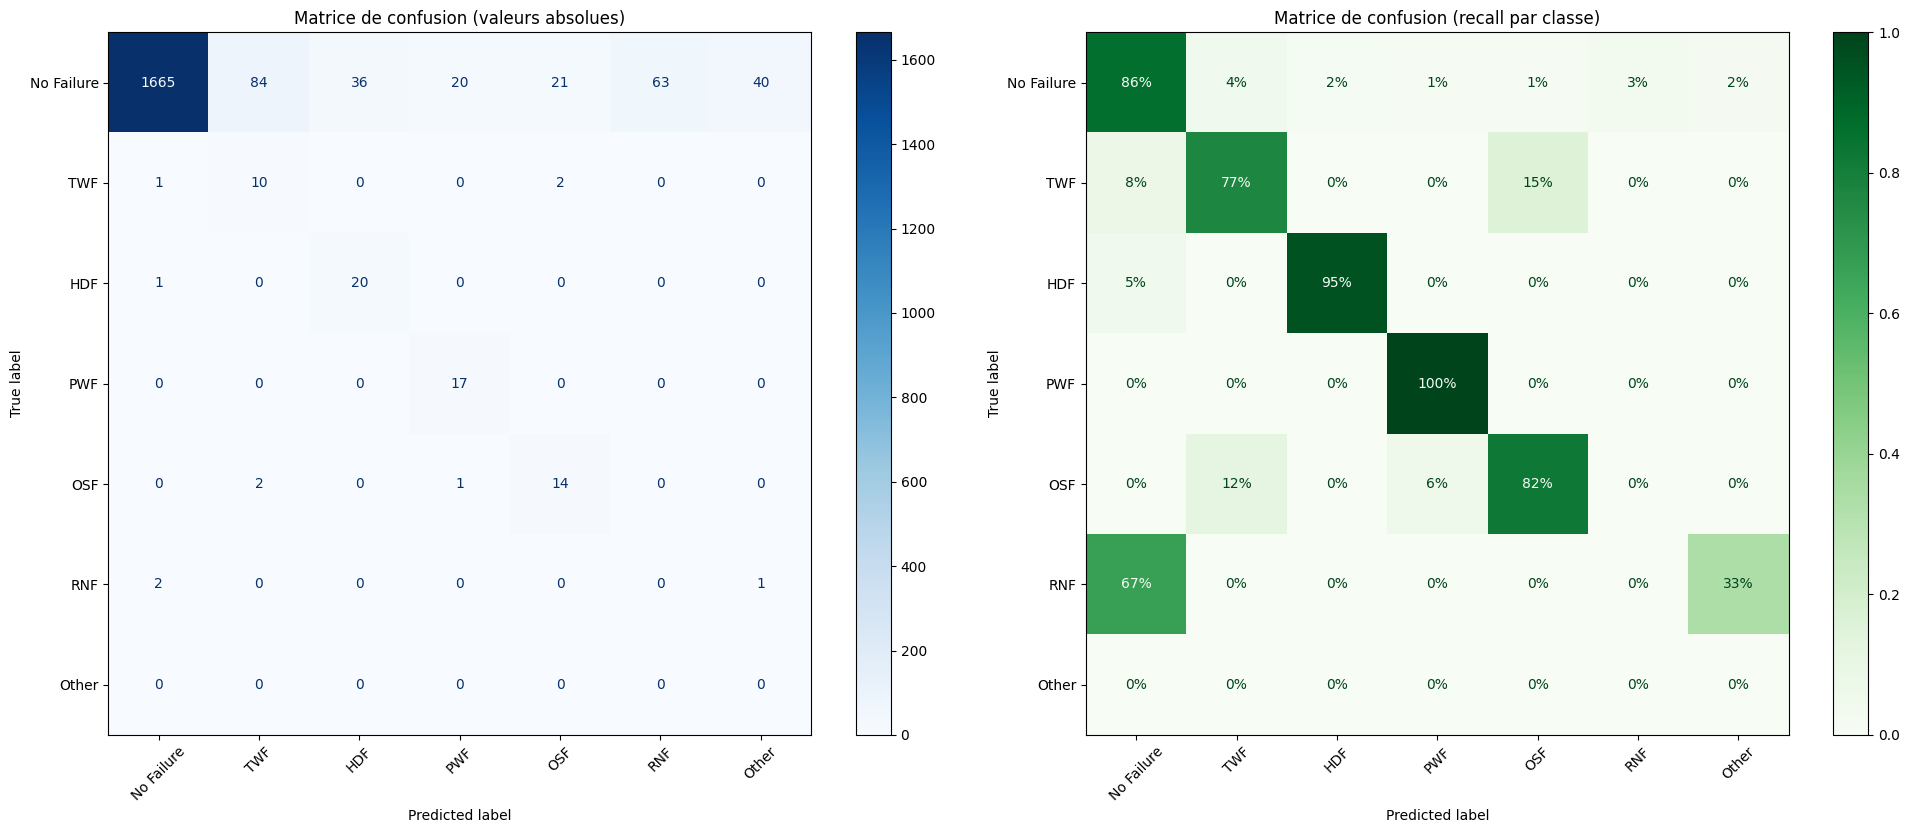

In [107]:
# Prédictions du modèle équilibré
y_pred_probs_bal = model_bal.predict(X_test_bal)
y_pred_bal = np.argmax(y_pred_probs_bal, axis=1)

# Classification report
class_names = ['No Failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'Other']
print("--- Classification Report (Données équilibrées - SMOTE 30%) ---")
print(classification_report(y_test, y_pred_bal, target_names=class_names, zero_division=0))

# Matrices de confusion
cm = confusion_matrix(y_test, y_pred_bal)
cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
cm_norm = np.nan_to_num(cm_norm)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

disp1 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp1.plot(ax=axes[0], cmap='Blues', xticks_rotation=45)
axes[0].set_title('Matrice de confusion (valeurs absolues)')

disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=class_names)
disp2.plot(ax=axes[1], cmap='Greens', xticks_rotation=45, values_format='.0%')
axes[1].set_title('Matrice de confusion (recall par classe)')

plt.tight_layout()
plt.show()

**ANALYSIS QUESTION** What do you observe? What can you conclude?

Grâce au rééquilibrage par SMOTE partiel (30%) et une architecture régularisée (32→16→7, Dropout 0.2, L2), les courbes d'entraînement montrent une bonne convergence sans overfitting : la training accuracy (0.85) et la validation accuracy (0.84) sont proches, et la validation loss ne diverge pas.s

La matrice de confusion normalisée révèle que le modèle détecte efficacement les pannes : PWF à 100%, HDF à 95%, OSF à 76% et TWF à 62%. Comparé au modèle non équilibré de la Partie 2 qui prédisait quasi exclusivement "No Failure", c'est une nette amélioration dans la détection des classes minoritaires.

Le compromis se situe sur la classe "No Failure" : environ 15% des machines saines sont classées comme en panne (faux positifs), ce qui fait baisser l'accuracy globale de 97% à 84%. Cependant, en contexte de maintenance prédictive industrielle, ce compromis est largement acceptable : une fausse alerte engendre une inspection inutile, tandis qu'une panne non détectée peut provoquer un arrêt de production coûteux voire des dégâts matériels.

Les limites du modèle restent la classe RNF (0% de détection, seulement 3 exemples dans le test set) et la classe "Other" absente du test. Ces classes sont trop rares pour que même le SMOTE puisse générer des exemples synthétiques de qualité suffisante.

En conclusion, le modèle avec SMOTE est nettement plus adapté à un déploiement sur STM32 pour une mission de maintenance prédictive, car il offre un bon équilibre entre détection des pannes et taux de fausses alarmes.

In [108]:
# Sauvegarde du modèle Keras (.h5) pour import dans STM32CubeAI
model_bal.save('model_maintenance.h5')
print("Modèle sauvegardé : model_maintenance.h5")

# Sauvegarde des données de test (X et Y) pour validation sur la carte
np.save('X_test.npy', X_test_bal)
np.save('y_test.npy', y_test.values)
print(f"X_test sauvegardé : {X_test_bal.shape}")
print(f"y_test sauvegardé : {y_test.shape}")

# Téléchargement
from google.colab import files
files.download('model_maintenance.h5')
files.download('X_test.npy')
files.download('y_test.npy')

Modèle sauvegardé : model_maintenance.h5
X_test sauvegardé : (2000, 6)
y_test sauvegardé : (2000,)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>